# LOESS Trend Analysis

In [1]:
from pathlib import Path
from functools import cache

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mgplot as mg
from statsmodels.nonparametric.smoothers_lowess import lowess  # type: ignore[import-untyped]
from IPython.display import display

from common import RFOOTER

LFOOTER = "Australia. Polling data sourced from Wikipedia. "
SHOW_PLOT = True

In [2]:
# Set up plotting directory
mg.set_chart_dir("../charts/LOESS-trend/")
mg.clear_chart_dir()

## Upload the data

In [3]:
def load_polling_data() -> pd.DataFrame:
    """Load the most recent polling data with data freshness validation."""
    today = pd.Timestamp.now().strftime("%Y-%m-%d")
    data_dir = Path("../poll-data")

    # Look for today's file first
    today_file = data_dir / f"voting_intention_next_{today}.csv"
    fallback_file = data_dir / "voting_intention_next.csv"

    if today_file.exists():
        data_path = today_file
        print(f"Using today's data file: {data_path}")
    else:
        # Look for any recent file with date suffix
        pattern = "voting_intention_next_*.csv"
        recent_files = list(data_dir.glob(pattern))

        help = "Consider running the scraper first: automated/scrape_wikipedia_polls.py"
        if recent_files:
            # Sort by filename (date suffix) and take most recent
            most_recent = sorted(recent_files)[-1]
            file_date = most_recent.stem.split("_")[-1]  # Extract date from filename

            print(f"⚠️  WARNING: No data file found for today ({today})")
            print(f"Using most recent file: {most_recent} (from {file_date})")
            print(help)
            data_path = most_recent
        elif fallback_file.exists():
            print("⚠️  WARNING: No dated data files found")
            print(f"Using fallback file: {fallback_file}")
            print(help)
            data_path = fallback_file
        else:
            raise FileNotFoundError(
                "No polling data files found. Please run the scraper first: python scrape_wikipedia_polls.py"
            )

    # Load the data
    df = pd.read_csv(data_path)
    df.index = pd.PeriodIndex(df["parsed_date"], freq="D")

    df = df.dropna(axis=1, how="all")  # drop all NAN columns

    return df


data = load_polling_data()

Using today's data file: ../poll-data/voting_intention_next_2025-09-17.csv


## Data Preview

In [4]:
def preview_polling_data(data: pd.DataFrame) -> None:
    """Display a preview of the polling data."""
    display(data.head(10))


# Show the data preview
preview_polling_data(data)

,Date,Brand,Interview mode,Sample size,Primary vote ALP,Primary vote L/NP,Primary vote GRN,Primary vote ONP,Primary vote IND,Primary vote OTH,2PP vote ALP,2PP vote L/NP,parsed_date,primary_data_complete,2pp_data_complete
parsed_date,,,,,,,,,,,,,,,
2025-09-11,9–13 Sep 2025,Resolve,Telephone/Online,1800,35.0,27.0,11.0,12.0,9.0,6.0,55.0,45.0,2025-09-11,True,True
2025-09-09,8-11 Sep 2025,Newspoll,Online,1283,36.0,27.0,13.0,10.0,NaN,14.0,58.0,42.0,2025-09-09,True,True
2025-08-29,19 Aug – 8 Sep 2025,Redbridge,Online,5326,35.0,30.0,11.0,11.0,NaN,13.0,53.5,46.5,2025-08-29,True,True
2025-08-10,28 Jul – 24 Aug 2025,Roy Morgan,Online,5001,34.0,30.0,12.0,9.0,NaN,15.0,56.5,43.5,2025-08-10,True,True
2025-08-13,11–15 Aug 2025,Resolve,Telephone/Online,1800,37.0,29.0,12.0,9.0,8.0,6.0,59.0,41.0,2025-08-13,True,True
2025-08-12,11–14 Aug 2025,Newspoll,Online,1283,36.0,30.0,12.0,9.0,NaN,13.0,56.0,44.0,2025-08-12,True,True
2025-07-24,18–30 Jul 2025,Wolf & Smith,—,5000,36.0,30.0,NaN,NaN,NaN,NaN,57.0,43.0,2025-07-24,False,True
2025-07-13,30 Jun – 27 Jul 2025,Roy Morgan,Online,5159,36.5,31.0,12.0,7.0,NaN,13.5,57.0,43.0,2025-07-13,True,True
2025-07-15,13–18 Jul 2025,Resolve,Telephone/Online,2311,35.0,29.0,12.0,8.0,8.0,8.0,56.0,44.0,2025-07-15,True,True


## LOESS Smoothing

In [5]:
def create_loess_smoothing(data: pd.DataFrame, column: str, day_span=90) -> pd.Series:
    """Create LOESS smoothing and return smoothed data."""
    # Sort by index (PeriodIndex) instead of 'date' column to avoid ambiguity
    df_2pp_sorted = data.sort_index().copy()

    # Apply LOESS smoothing
    series = df_2pp_sorted[column].dropna()
    dates_as_ordinals = [p.ordinal for p in series.index]
    denominator = np.max(dates_as_ordinals) - np.min(dates_as_ordinals)
    fraction = day_span / denominator if denominator else 1
    fraction = fraction if fraction < 1 else 1
    smoothed = lowess(
        df_2pp_sorted[column].dropna(),
        dates_as_ordinals,
        frac=fraction,  # Smoothing parameter - adjust as needed
    )
    smoothed_series = pd.Series(smoothed[:, 1], index=series.index)
    smoothed_series.name = f"LOESS {day_span}-day smoothing"
    smoothed_series = smoothed_series[~smoothed_series.index.duplicated(keep="first")]

    return smoothed_series

In [6]:
@cache
def get_last_election() -> pd.Series:
    """Retrieve the latest election results for annotations."""    

    # Capture latest value for 2025 election annotations
    election_df = pd.read_csv(
        "../historic-data/election-outcomes.csv",
        sep=' ',
        skipinitialspace=True,
        header=0,
        comment='#',
        na_values=["", "-"],
    ).fillna(0)  # make sure NA values are 0 for numeric conversion
    for col in election_df.columns:
        try:
            election_df[col] = pd.to_numeric(election_df[col])
        except ValueError:
            continue
    df_numeric = election_df.select_dtypes(include=['number'])
    election_2025 = df_numeric[df_numeric["Year"] == 2025].iloc[0]

    return election_2025


e25 = get_last_election()
print(e25, e25[1:-1].sum())

Year        2025.00
ALP           34.56
LP            20.69
LNP            7.10
NP             3.80
CLP            0.23
DLP            0.00
DEM            0.00
GRN           12.20
ON             6.40
UAP            1.91
Others        13.11
Labor2pp      55.22
Name: 30, dtype: float64 100.00000000000001


In [7]:
def create_chart_with_loess(
    df_2pp: pd.DataFrame,
    smoothed: pd.Series,
    color: str,
    name: str,
    col: str,
    f: str = "",
) -> None:
    """Create and display the LOESS chart with polling data."""

    _fig, ax = plt.subplots()
    symbols = ["o", "s", "^", "v", "<", ">", "D", "x", "v"]
    for i, label in enumerate(sorted(df_2pp["Brand"].unique())):
        selection = df_2pp[df_2pp["Brand"] == label][col]
        if selection.empty or selection.isna().all():
            continue
        x = [p.ordinal for p in selection.index]
        y = selection.to_numpy()
        ax.scatter(
            x, y, label=label, color=color, s=20, marker=symbols[i % len(symbols)]
        )
    
    # Calculate Coalition and Others totals
    election_2025 = get_last_election()
    coalition_primary = election_2025["LP"] + election_2025["LNP"] + election_2025["NP"] + election_2025["CLP"]
    others_primary = 100 - election_2025["ALP"] - coalition_primary - election_2025["GRN"] - election_2025["ON"]
    
    # Map column names to 2025 results
    results_map = {
        "2PP vote ALP": election_2025["Labor2pp"],
        "2PP vote L/NP": 100 - election_2025["Labor2pp"],
        "Primary vote ALP": election_2025["ALP"],
        "Primary vote L/NP": coalition_primary,
        "Primary vote GRN": election_2025["GRN"],
        "Primary vote ONP": election_2025["ON"],
        "Others Primary Vote": others_primary,
    }
    
    if col in results_map:
        result = results_map[col]
        ax.axhline(y=result, color=color, linestyle="--", alpha=0.6, linewidth=1.5,
                   label=f"2025 Result: {result:.1f}%")

    mg.line_plot_finalise(
        smoothed,
        ax=ax,
        title=f"{name} - {col} - Trend",
        xlabel=None,
        ylabel=f"{col} (%)",
        legend=True,
        width=2.5,
        color=color,
        rfooter=RFOOTER,
        lfooter=f"{LFOOTER} {f} n={len(df_2pp[col].dropna())} polls. ".replace("  ", " ").replace("  ", " "),
        show=SHOW_PLOT,
    )

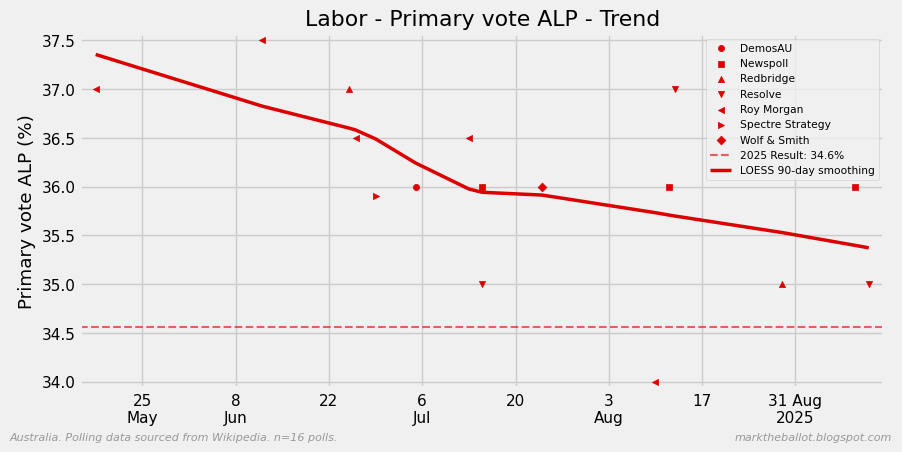

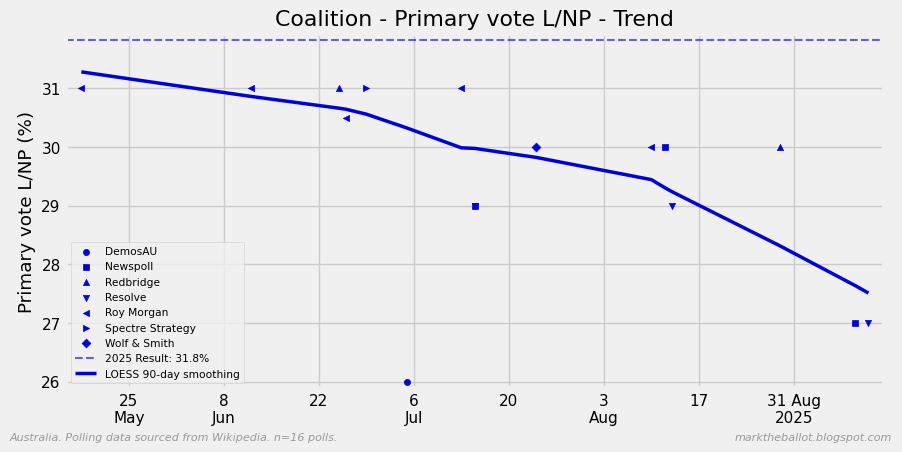

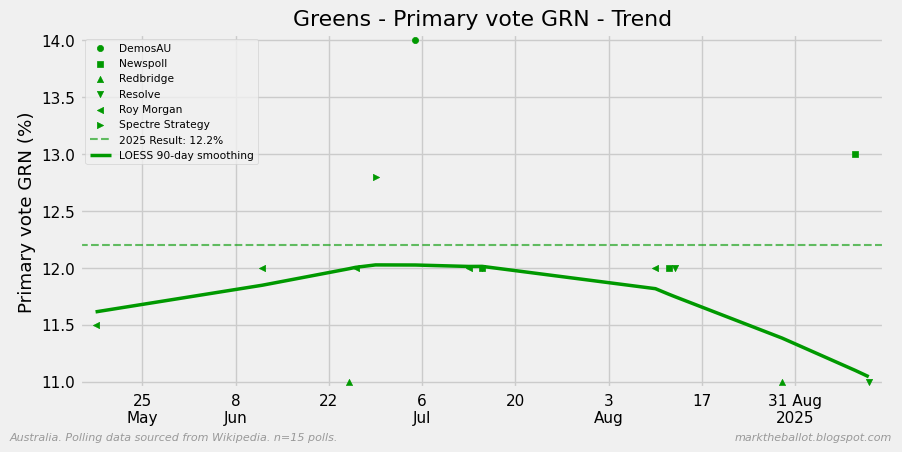

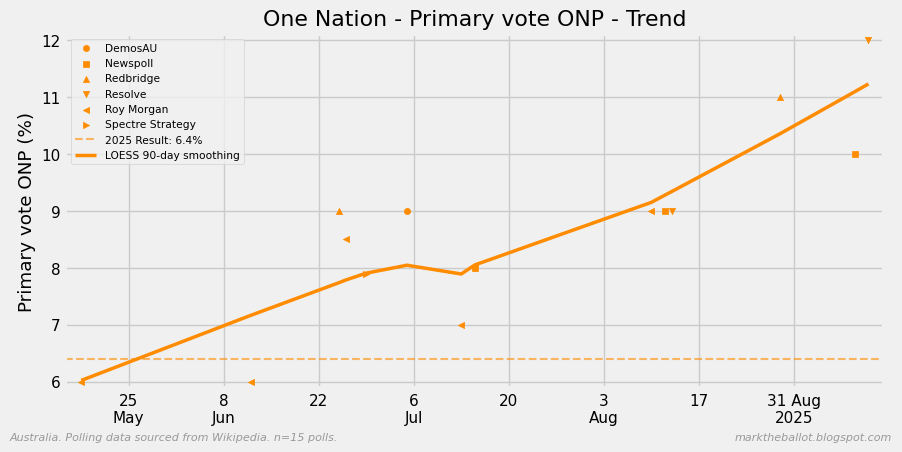

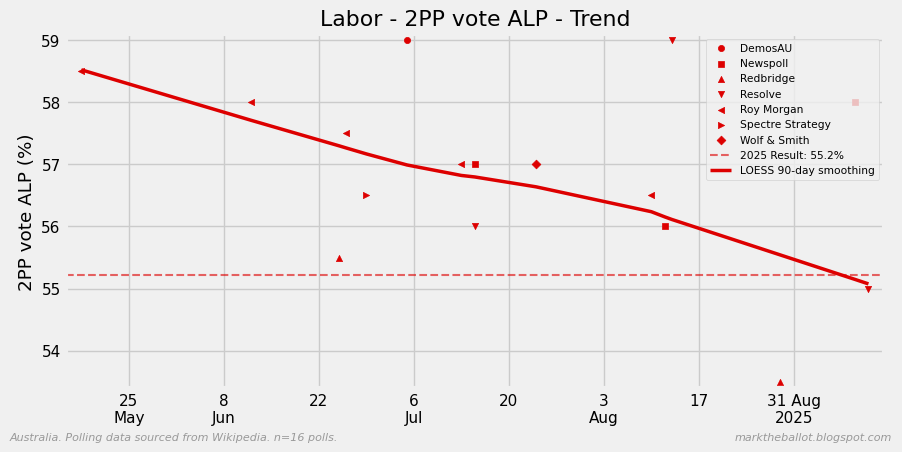

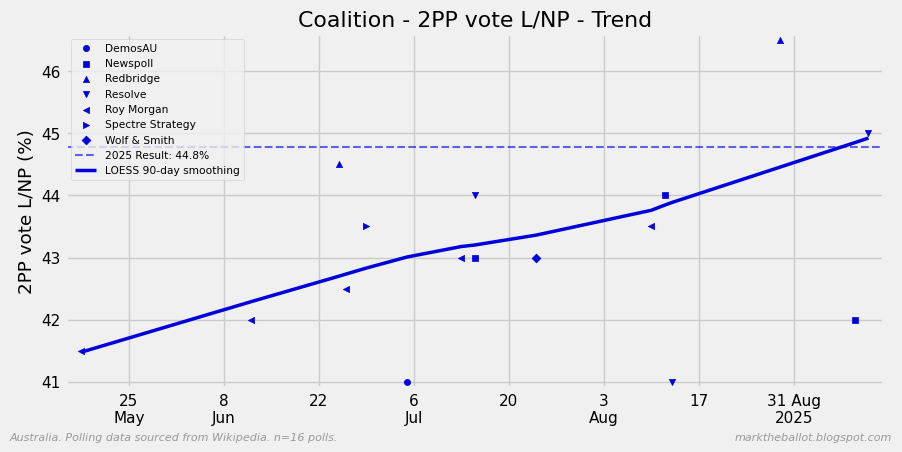

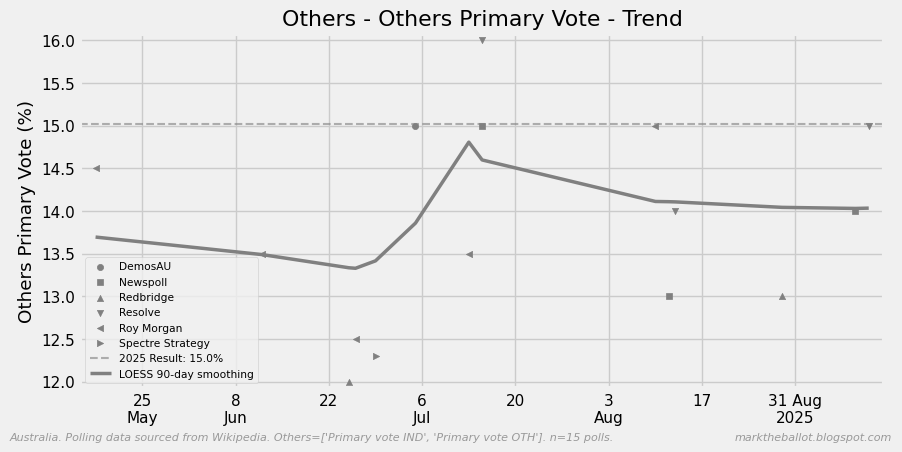

In [8]:
wanted = {
    # party: [name, color]
    "ALP": ["Labor", "#dd0000"],
    "L/NP": ["Coalition", "#0000dd"],
    "GRN": ["Greens", "#009900"],
    "ONP": ["One Nation", "darkorange"],
}
used = []
for col in data.columns:
    if "vote" not in col:
        continue
    for w in wanted:
        if w in col:
            used.append(col)
            name, color = wanted[w]
            smoothed = create_loess_smoothing(data, col)
            create_chart_with_loess(
                data,
                smoothed,
                color,
                name,
                col,
            )

# Create chart for "Others Primary Vote"
remaining = [w for w in data.columns if w not in used and "vote" in w]
col = "Others Primary Vote"
data[col] = data[remaining].sum(axis=1, skipna=True)
problematic = data[remaining].isna().all(axis=1)
data.loc[problematic, col] = np.nan  # Ensure problematic rows are NaN
smoothed = create_loess_smoothing(data, col)
create_chart_with_loess(
    data, smoothed, "grey", "Others", col, f=f"Others={remaining}. "
)

## Finished

In [9]:
%load_ext watermark
%watermark -t -d -u --python --machine --conda --iversions --watermark

Last updated: 2025-09-17 09:38:33

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas     : 2.3.1
IPython    : 9.4.0
matplotlib : 3.10.5
mgplot     : 0.2.12
pathlib    : 1.0.1
statsmodels: 0.14.5
numpy      : 2.3.2

Watermark: 2.5.0



In [10]:
print("The end.")

The end.
